In [1]:
import numpy as np
import glob
import pypianoroll as ppr
import time
import music21
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from utils.utilsPreprocessing import *
import matplotlib
#matplotlib.use('Agg')
#np.set_printoptions(threshold=np.inf)
#torch.set_printoptions(threshold=50000)

In [2]:
##################################
#HYPERPARAMS
##################################
epochs = 3
learning_rate = 1e-4
batch_size= 400
log_interval = 1  #Log/show loss per batch
embedding_size=100

# Load MIDI files from npz

In [3]:
data = np.load('../WikifoniaPartlyNoTranspose.npz')

midiDatasetTrain = data['train']
midiDatasetTest = data['test']

data.close()

"""
print("Training set: ({}, {}, {}, {})".format(midiDatasetTrain.size()[0],
                                                midiDatasetTrain.size()[1],
                                                midiDatasetTrain.size()[2],
                                                midiDatasetTrain.size()[3]))
print("Test set: ({}, {}, {}, {})".format(midiDatasetTest.size()[0],
                                                midiDatasetTest.size()[1],
                                                midiDatasetTest.size()[2],
                                                midiDatasetTest.size()[3]))
"""

print("Training set: {}".format(midiDatasetTrain.shape))
print("Test set: {}".format(midiDatasetTest.shape))

Training set: (4056, 1, 96, 60)
Test set: (1034, 1, 96, 60)


In [4]:
#print(getSlicedPianorollMatrix('WikifoniaServer/train80/Ahmad-Jamal---Poinciana.mid').shape)

In [5]:
fullPitch = 128
_, _, length, reducedPitch = midiDatasetTrain.shape

# VAE model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
midiDatasetTrain = torch.from_numpy(midiDatasetTrain)#.float()
trainLoader = torch.utils.data.DataLoader(midiDatasetTrain, batch_size=batch_size, shuffle=True, drop_last=True)

midiDatasetTest = torch.from_numpy(midiDatasetTest)#.float()
testLoader = torch.utils.data.DataLoader(midiDatasetTest, batch_size=batch_size, shuffle=True, drop_last=True)

In [8]:
class VAE(nn.Module):
    def __init__(self, embedding_size=100):
        super(VAE, self).__init__()
        
        self.embedding_size = embedding_size
        
        ###ENCODER###
        self.encode1 = nn.Sequential(
            nn.Conv2d(1,100,(16,5),stride=(16,5),padding=0),
            nn.BatchNorm2d(100),
            nn.ELU(),
            nn.Conv2d(100,200,(2,1),stride=(2,1),padding=0),
            nn.BatchNorm2d(200),
            nn.ELU(),
            nn.Conv2d(200,400,(2,2),stride=(1,2),padding=0),
            nn.BatchNorm2d(400),
            nn.ELU(),
            nn.Conv2d(400,800,(2,2),stride=(2,2),padding=0),
            nn.BatchNorm2d(800),
            nn.ELU()
        )
            
        self.encode2 = nn.Sequential(
            nn.Linear(2400,800),
            nn.BatchNorm1d(800),
            nn.ELU(),
            nn.Linear(800,400),
            nn.BatchNorm1d(400),
            nn.ELU()
            #nn.Linear(400,100),
            #nn.BatchNorm1d(100),
            #nn.ELU()
        )
        self.encode31 = nn.Sequential(
            nn.Linear(400,self.embedding_size),
            nn.BatchNorm1d(self.embedding_size),
            nn.ELU()
        )
        self.encode32 = nn.Sequential(
            nn.Linear(400,self.embedding_size),
            nn.BatchNorm1d(self.embedding_size),
            nn.ELU()
        )

        ###DECODER###
        self.decode1 = nn.Sequential(
            nn.Linear(self.embedding_size,400),
            nn.BatchNorm1d(400),
            nn.ELU(),
            nn.Linear(400,800),
            nn.BatchNorm1d(800),
            nn.ELU(),
            nn.Linear(800,2400),
            nn.BatchNorm1d(2400),
            nn.ELU()
        )
        self.decode2 = nn.Sequential(
            nn.ConvTranspose2d(800,400,(2,2),stride=(2,2),padding=0),
            nn.BatchNorm2d(400),
            nn.ELU(),
            nn.ConvTranspose2d(400,200,(2,2),stride=(1,2),padding=0),
            nn.BatchNorm2d(200),
            nn.ELU(),
            nn.ConvTranspose2d(200,100,(2,1),stride=(2,1),padding=0),
            nn.BatchNorm2d(100),
            nn.ELU(),
            nn.ConvTranspose2d(100,1,(16,5),stride=(16,5),padding=0),
            nn.BatchNorm2d(1),
            nn.ELU()
        )
    
    def encoder(self, hEnc):
        #print("ENOCDER")
        hEnc = self.encode1(hEnc)
        hEnc = torch.squeeze(hEnc,3).view(-1,800*3)
        hEnc = self.encode2(hEnc)
        hEnc1 = self.encode31(hEnc)
        hEnc2 = self.encode32(hEnc)
        return hEnc1, hEnc2

    def decoder(self, z):
        #print("DECODER")
        hDec = self.decode1(z)
        hDec = hDec.view(hDec.size()[0],800,-1).unsqueeze(2)
        hDec = self.decode2(hDec)
        return hDec

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.2*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            #print("no change")
            return mu
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar
    
model = VAE(embedding_size=embedding_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def loss_function(recon_x, x, mu, logvar):
    
    cos = nn.CosineSimilarity(dim=1, eps=1e-8) 
    #beta for disentanglement
    beta = 1e0 
    
    ###NESTED COSINE SIMILARITY SOFTMAX LOSS 
    ###WITH 4 RANDOM RECONSTRUCTED VECTORS
    ###WHICH INCLUDES NEGATIVE EXAMPLES OF RECONSTRUCTIONS
    if(False):#model.training): 
        sftmax = nn.Softmax(dim=0)
        lenDataset = dataset.size()[0]
        #print(lenDataset)
        softmax = 0
        for orgInput, recon in zip(x, recon_x):
                     
            #HAVE TO DO IT LIKE THIS BECAUSE BATCHSIZE 1 DOESN'T WORK IN PYTORCH
            rand = np.random.randint(0,lenDataset-1)
            randomRecons = dataset[rand:rand+1,:,:,:] 
            for i in range(3):
                rand = np.random.randint(0,lenDataset-1)
                randomTemp = dataset[rand:rand+1,:,:,:]
                randomRecons = torch.cat((randomRecons,randomTemp),dim=0)
            with torch.no_grad():
                randomRecons, _ = model(randomRecons.float().to(device))
            #COMPUTE COSINE SIMILARITY FOR ORIGINAL INPUT
            #AND ITS RECONSTRUCTION
            cosSimOrg = cos(orgInput.view(1,-1),recon.view(1,-1))
            
            #INCLUDE NEGATIVE EXAMPLES WITH SOFTMAX
            cosSim = cos(orgInput.view(1,-1),randomRecons[0].view(1,-1))
            for randomRecon in randomRecons[1:]:
                cosTemp = cos(orgInput.view(1,-1),randomRecon[0].view(1,-1))
                cosSim = torch.cat((cosSim, cosTemp),dim=0)
            cosSoftmax = torch.cat((cosSimOrg,cosSim),dim=0)            
            softmax += sftmax(cosSoftmax)[0]
            
        return -softmax
    #OLDLOSS JUST COSINE SIMILARITY ON RECONSTRUCTION (GOOD FOR TESTING?)
    else:
        """
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + KLD
        """
        #BCE2 = F.binary_cross_entropy(recon_x.view(-1,96*60),
        #                             x.view(-1, 96*60),
        #                             size_average=False)
        
        #BCELoss = nn.BCEWithLogitsLoss(reduction='sum')
        #BCE = BCELoss(recon_x.view(-1,96*60),x.view(-1,96*60))
        
        cosSim = torch.sum(cos(x.view(100,-1),recon_x.view(100,-1)))
        cosSim = x.size()[0]-cosSim
        
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        KLD /= mu.size()[0]*mu.size()[1]
        #print(cosSim);print(KLD)
        return cosSim + (beta * KLD)
        

def train(epoch):
    model.train()
    trainLoss = 0

    for batch_idx, data in enumerate(trainLoader):
        ###DENOISING AUTOENCODER
        #data = data.float().to(device)
        #noise = torch.bernoulli((torch.rand_like(data))).to(device)
        #print(noise[0])
        #noisyData = data+noise
        #reconBatch, mu = model(noisyData)
        
        ###NORMAL AUTOENCODER
        data = data.float().to(device)
        optimizer.zero_grad()
        reconBatch, mu, logvar = model(data)

        loss = loss_function(reconBatch, data, mu, logvar)
        loss.backward()
        trainLoss += loss.item()
        optimizer.step()
        if(batch_idx % log_interval == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainLoader.dataset),
                100. * batch_idx / len(trainLoader),
                loss.item() / len(data)))
        #if (batch_idx == 10):
        #    break

    print('====> Epoch: {} Average Loss: {:.4f}'.format(
          epoch, trainLoss / len(trainLoader.dataset)))
    return trainLoss / len(trainLoader.dataset)

def test(epoch):
    model.eval()
    testLoss = 0
    with torch.no_grad():
        for i, data in enumerate(testLoader):
            ###DENOISING AUTOENCODER
            #data = data.float().to(device)
            #noise = torch.bernoulli((torch.rand_like(data))).to(device)
            #noisyData = data+noise
            #reconBatch, mu = model(noisyData)
            
            ###NORMAL AUTOENCODER
            data = data.float().to(device)
            reconBatch, mu, logvar = model(data)
            
            #TEMP
            randomRecons = torch.zeros(1,1,60,96).to(device)
            #TEMP END
            testLoss += loss_function(reconBatch, data, mu, logvar).item()
            #if(i==10):
            #    break
    testLoss /= len(testLoader.dataset)

    print('====> Test set loss: {:.4f}'.format(testLoss))
    return testLoss

# Load Model

In [9]:
from loadModel import loadModel
pathToModel = '../models/YamahaPC2002_VAE_Reconstruct_NoTW_20Epochs.model'

model = loadModel(model,pathToModel, dataParallelModel=False)



--------GPU model restored--------



# Train

In [ ]:
"""
import matplotlib.pyplot as plt

trainLosses = []
testLosses = []
for epoch in range(1, epochs + 1):
    trainLosses.append(train(epoch))
    testLosses.append(test(epoch))
    
plt.plot(trainLosses, color='red', label='Train Loss')
plt.plot(testLosses, color='orange', label='Test Loss')
plt.legend()
plt.savefig('VAE_Loss.png')
"""
print('')

In [ ]:
#torch.save(model,'/media/EXTHD/niciData/models/YamahaPC2002_DenoisingCVAE_Reconstruct_NoTW_5Epochs.model')

# Generate

In [ ]:
#np.set_printoptions(precision=4, suppress=True, threshold=np.inf)


INPUT


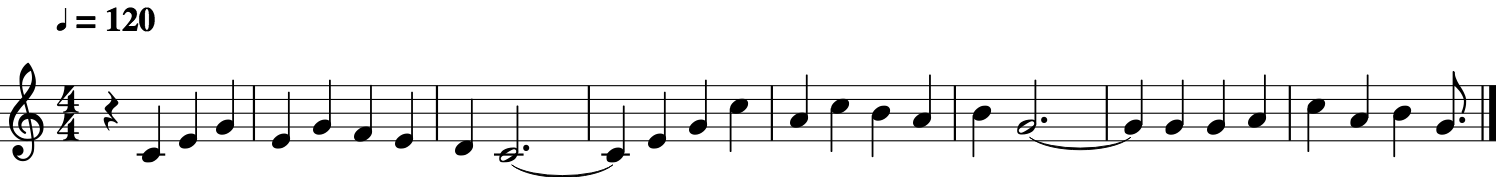

RECONSTRUCTION


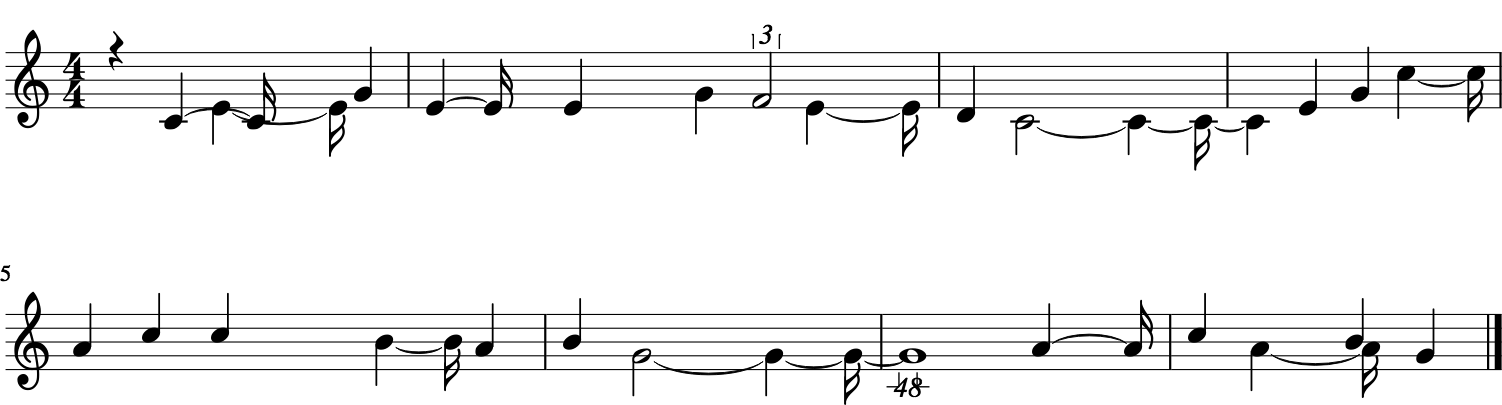

In [10]:

if(model.train()):
    model.eval()
    
###PLAY WHOLE SONG IN BARS
with torch.no_grad():
    sampleNp1 = getSlicedPianorollMatrixNp("../WikifoniaDatabase/test/Hermann-Lohr,-D.-Eardley-Wilmot---Little-Grey-Home-In-The-West.mid")
    sampleNp1 = deleteZeroMatrices(sampleNp1)
    
    for i,sampleNp in enumerate(sampleNp1[:8]):
        sampleNp = sampleNp[:,36:-32]
        sample = torch.from_numpy(sampleNp).float()
        embed, logvar = model.encoder(sample.reshape(1,1,length,reducedPitch).to(device))
        ###RECONSTRUCTION#########
        pred = model.decoder(embed)
        ##########################
        ###RANDOM RECONSTRUCTION##
        std = torch.exp(0.2*logvar)
        eps = torch.randn_like(std)
        randomRecon = model.decoder(eps.mul(std).add_(embed))
        ##########################

        reconstruction = pred.squeeze(0).squeeze(0).cpu().numpy()
        randomRecon = randomRecon.squeeze(0).squeeze(0).cpu().numpy()

        #NORMALIZE PREDICTIONS
        reconstruction /= np.abs(np.max(reconstruction))
        randomRecon /= np.abs(np.max(randomRecon))

        #CHECK MIDI ACTIVATIONS IN PREDICTION TO INCLUDE RESTS
        reconstruction[reconstruction < 0.2] = 0
        randomRecon[randomRecon < 0.3] = 0

        samplePlay = debinarizeMidi(sampleNp, prediction=False)
        samplePlay = addCuttedOctaves(samplePlay)
        reconstruction = debinarizeMidi(reconstruction, prediction=True)
        reconstruction = addCuttedOctaves(reconstruction)
        randomRecon = debinarizeMidi(randomRecon, prediction=True)
        randomRecon = addCuttedOctaves(randomRecon)
        if(i==0):
            sampleOut = samplePlay
            reconOut = reconstruction
            randomReconOut = randomRecon
        else:
            sampleOut = np.concatenate((sampleOut,samplePlay), axis=0)
            reconOut = np.concatenate((reconOut,reconstruction), axis=0)
            randomReconOut = np.concatenate((randomReconOut, randomRecon),axis=0)


    print("INPUT")
    pianorollMatrixToTempMidi(sampleOut, show=True,showPlayer=True,autoplay=False,
                             path='../temp/inputTemp.mid')
    print("RECONSTRUCTION")
    pianorollMatrixToTempMidi(reconOut, show=True,showPlayer=True,autoplay=False,
                             path='../temp/reconTemp.mid')
    #print("Reconstruction with Noise")
    #pianorollMatrixToTempMidi(randomReconOut, show=True,showPlayer=True,autoplay=False,
    #                         path='../temp/noiseReconTemp.mid')  
    print("\n\n")
            

print('')

# Morph from one sequence to another in latent space

Take 2 embedded sequences and slowly morph it to the other one based on this formula: $c_\alpha=(1-\alpha)*z_1 + \alpha*z_2$ , where $z_1$ corresponds to the embedding of sample 1 and $z_2$ to sample 2.
(Source of formula: https://arxiv.org/pdf/1803.05428.pdf)

sample1 shape: (96, 60)
sample2 shape:  (96, 60)
alpha is  0.0


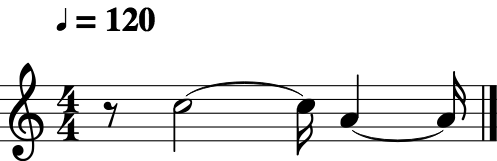

alpha is  0.1


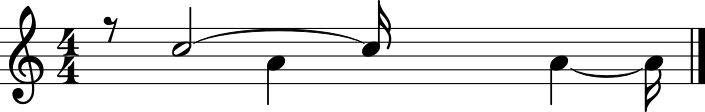

alpha is  0.2


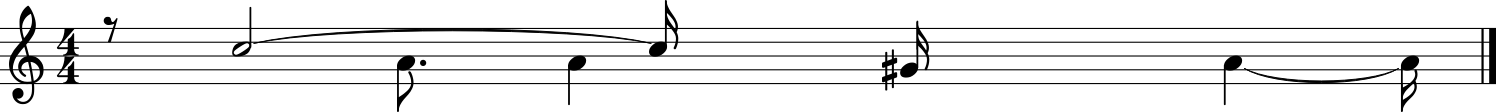

alpha is  0.3


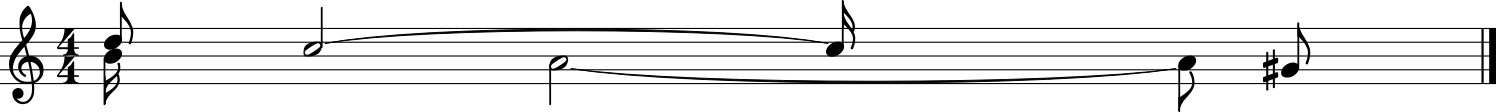

alpha is  0.4


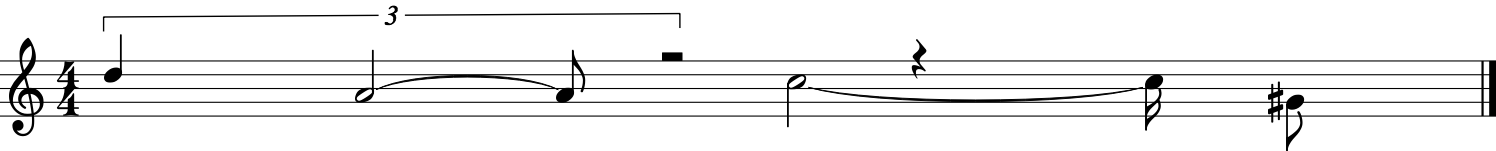

alpha is  0.5


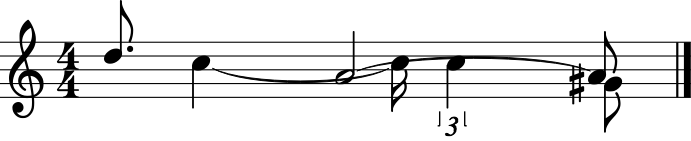

alpha is  0.6


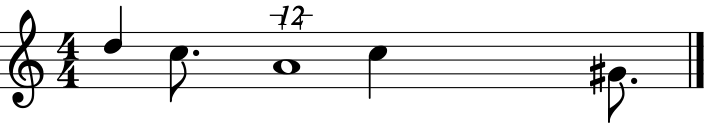

alpha is  0.7


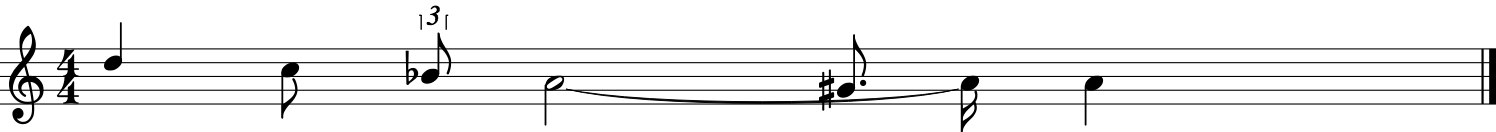

alpha is  0.8


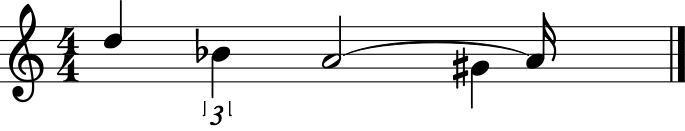

alpha is  0.9


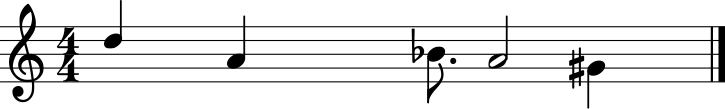

alpha is  1.0


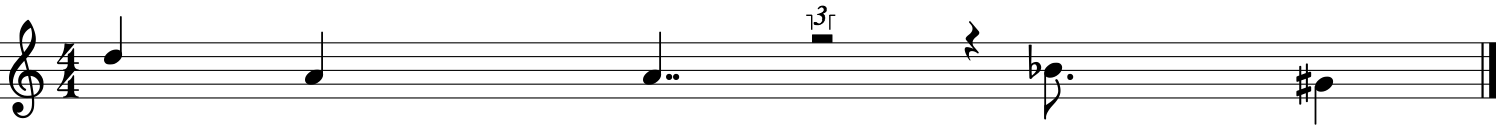

In [39]:
with torch.no_grad():
    #get 2 different unseeen sequences and choose random sequence
    sample1 = getSlicedPianorollMatrixNp('../WikifoniaDatabase/train/1952,-Jerry-Lieber-&-Mike-Stoller---Kansas-City.mid')
    sample1 = sample1[6,:,36:-32]
    sample2 = getSlicedPianorollMatrixNp('../WikifoniaDatabase/test/Hoagy-Carmichael---Blue-Orchids.mid')
    sample2 = sample2[7,:,36:-32]
    print('sample1 shape:', sample1.shape)
    print('sample2 shape: ',sample2.shape)

    #prepare for input
    sample1 = torch.from_numpy(sample1.reshape(1,1,96,60)).float().to(device)
    sample2 = torch.from_numpy(sample2.reshape(1,1,96,60)).float().to(device)
    
    #run through encoder
    embed1, _ = model.encoder(sample1)
    embed2, _ = model.encoder(sample2)
    
    for a in range(0,11):
        alpha = a/10
        print("alpha is ",alpha)
        c = (1-alpha) * embed1 + alpha * embed2
        
        #decode current
        recon = model.decoder(c)
        recon = recon.squeeze(0).squeeze(0).cpu().numpy()
        recon /= np.max(np.abs(recon))
        recon[recon < 0.2] = 0
        recon = debinarizeMidi(recon, prediction=True)
        recon = addCuttedOctaves(recon)
        pianorollMatrixToTempMidi(recon, show=True,showPlayer=False,autoplay=True,
                             path='../temp/temp.mid')
        
        
        